In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
from plotnine import *
from skimpy import clean_columns
import missingno as msno
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction
from sklearn.model_selection import train_test_split

/tmp/ipykernel_4474/1459437088.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
2023-09-14 09:02:40.180131: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Data Loading

In [2]:
# data from https://archive.ics.uci.edu/dataset/849/power+consumption+of+tetouan+city
power = clean_columns(pd.read_csv('powerconsumption.csv'))
print(power.head())
print(power.shape)

       date_time  temperature  humidity  wind_speed  general_diffuse_flows  \
0  1/1/2017 0:00        6.559      73.8       0.083                  0.051   
1  1/1/2017 0:10        6.414      74.5       0.083                  0.070   
2  1/1/2017 0:20        6.313      74.5       0.080                  0.062   
3  1/1/2017 0:30        6.121      75.0       0.083                  0.091   
4  1/1/2017 0:40        5.921      75.7       0.081                  0.048   

   diffuse_flows  zone_1_power_consumption  zone_2_power_consumption  \
0          0.119               34055.69620               16128.87538   
1          0.085               29814.68354               19375.07599   
2          0.100               29128.10127               19006.68693   
3          0.096               28228.86076               18361.09422   
4          0.085               27335.69620               17872.34043   

   zone_3_power_consumption  
0               20240.96386  
1               20131.08434  
2       

<Axes: >

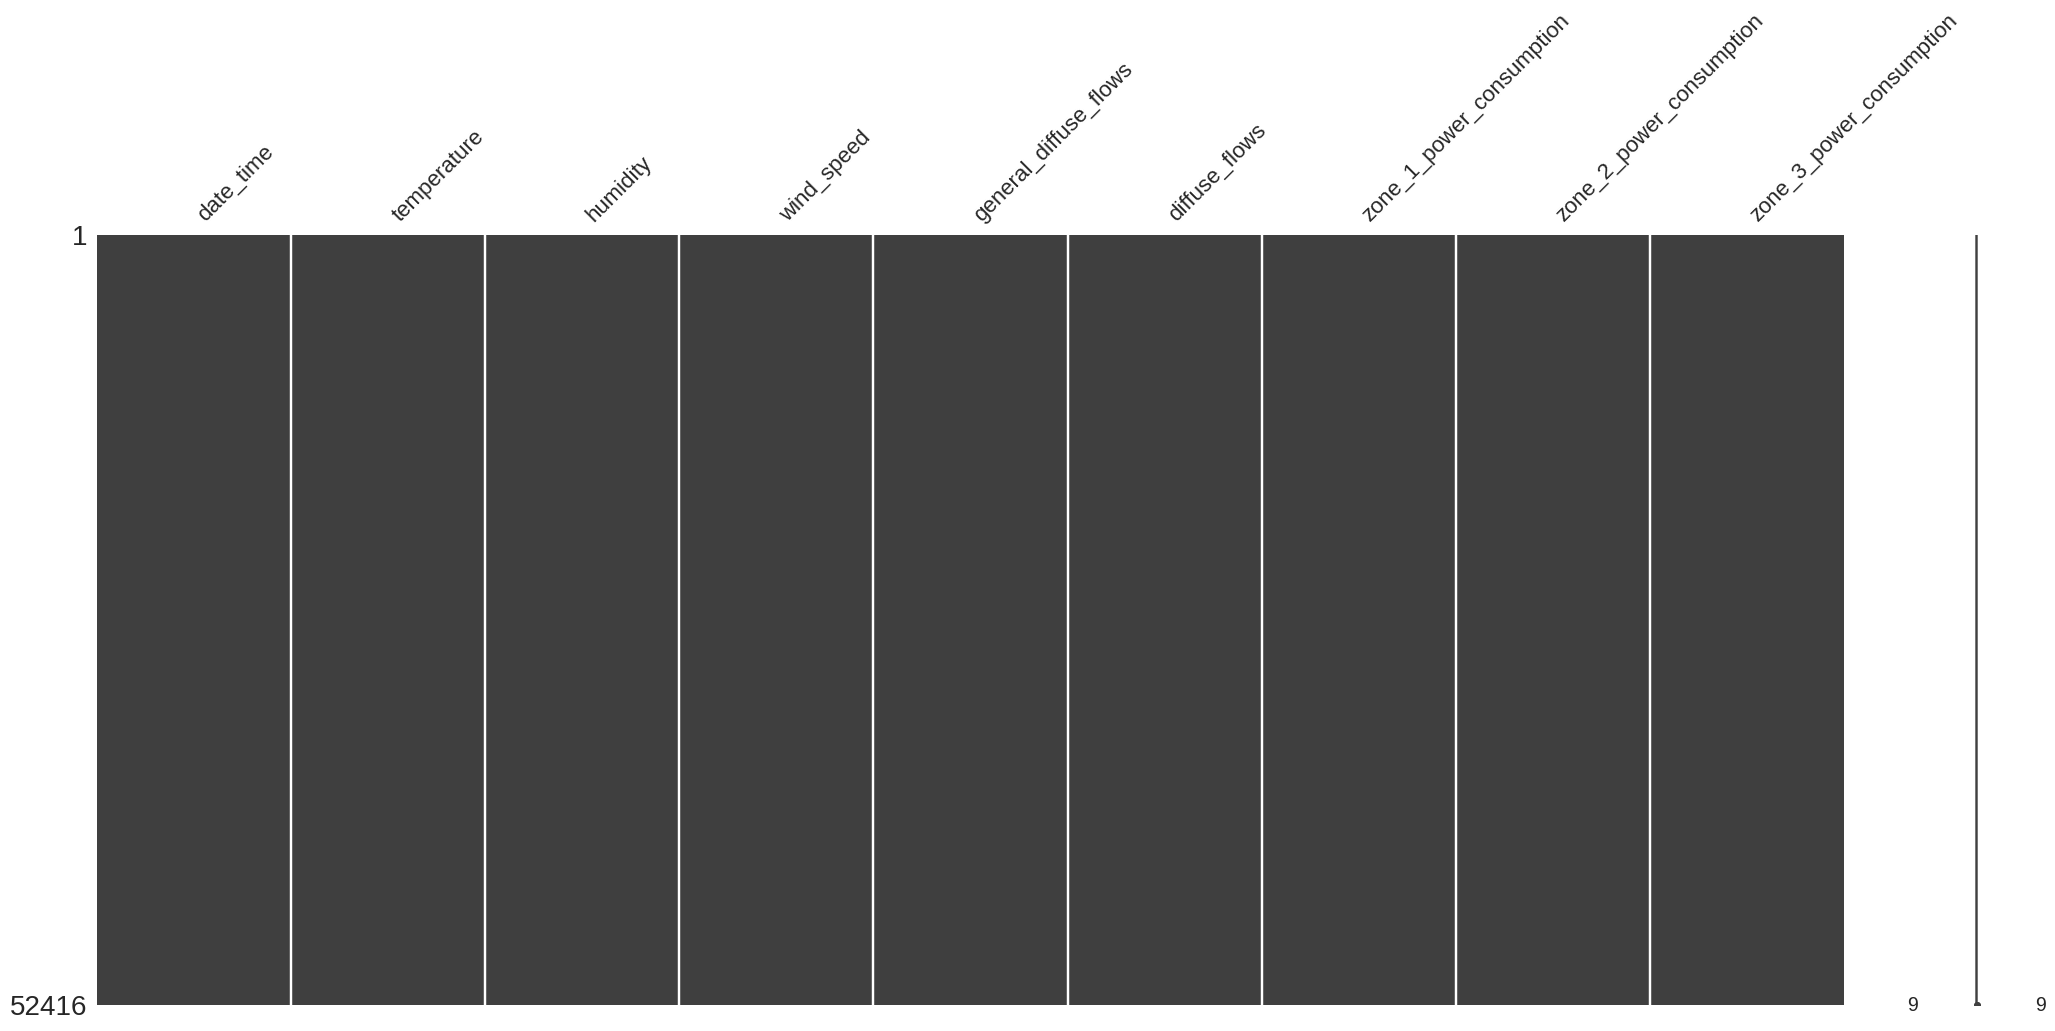

In [3]:
msno.matrix(power)

Hence, there are no missing values. Next, plot all pairs of numeric variables using the `pairplot` function.

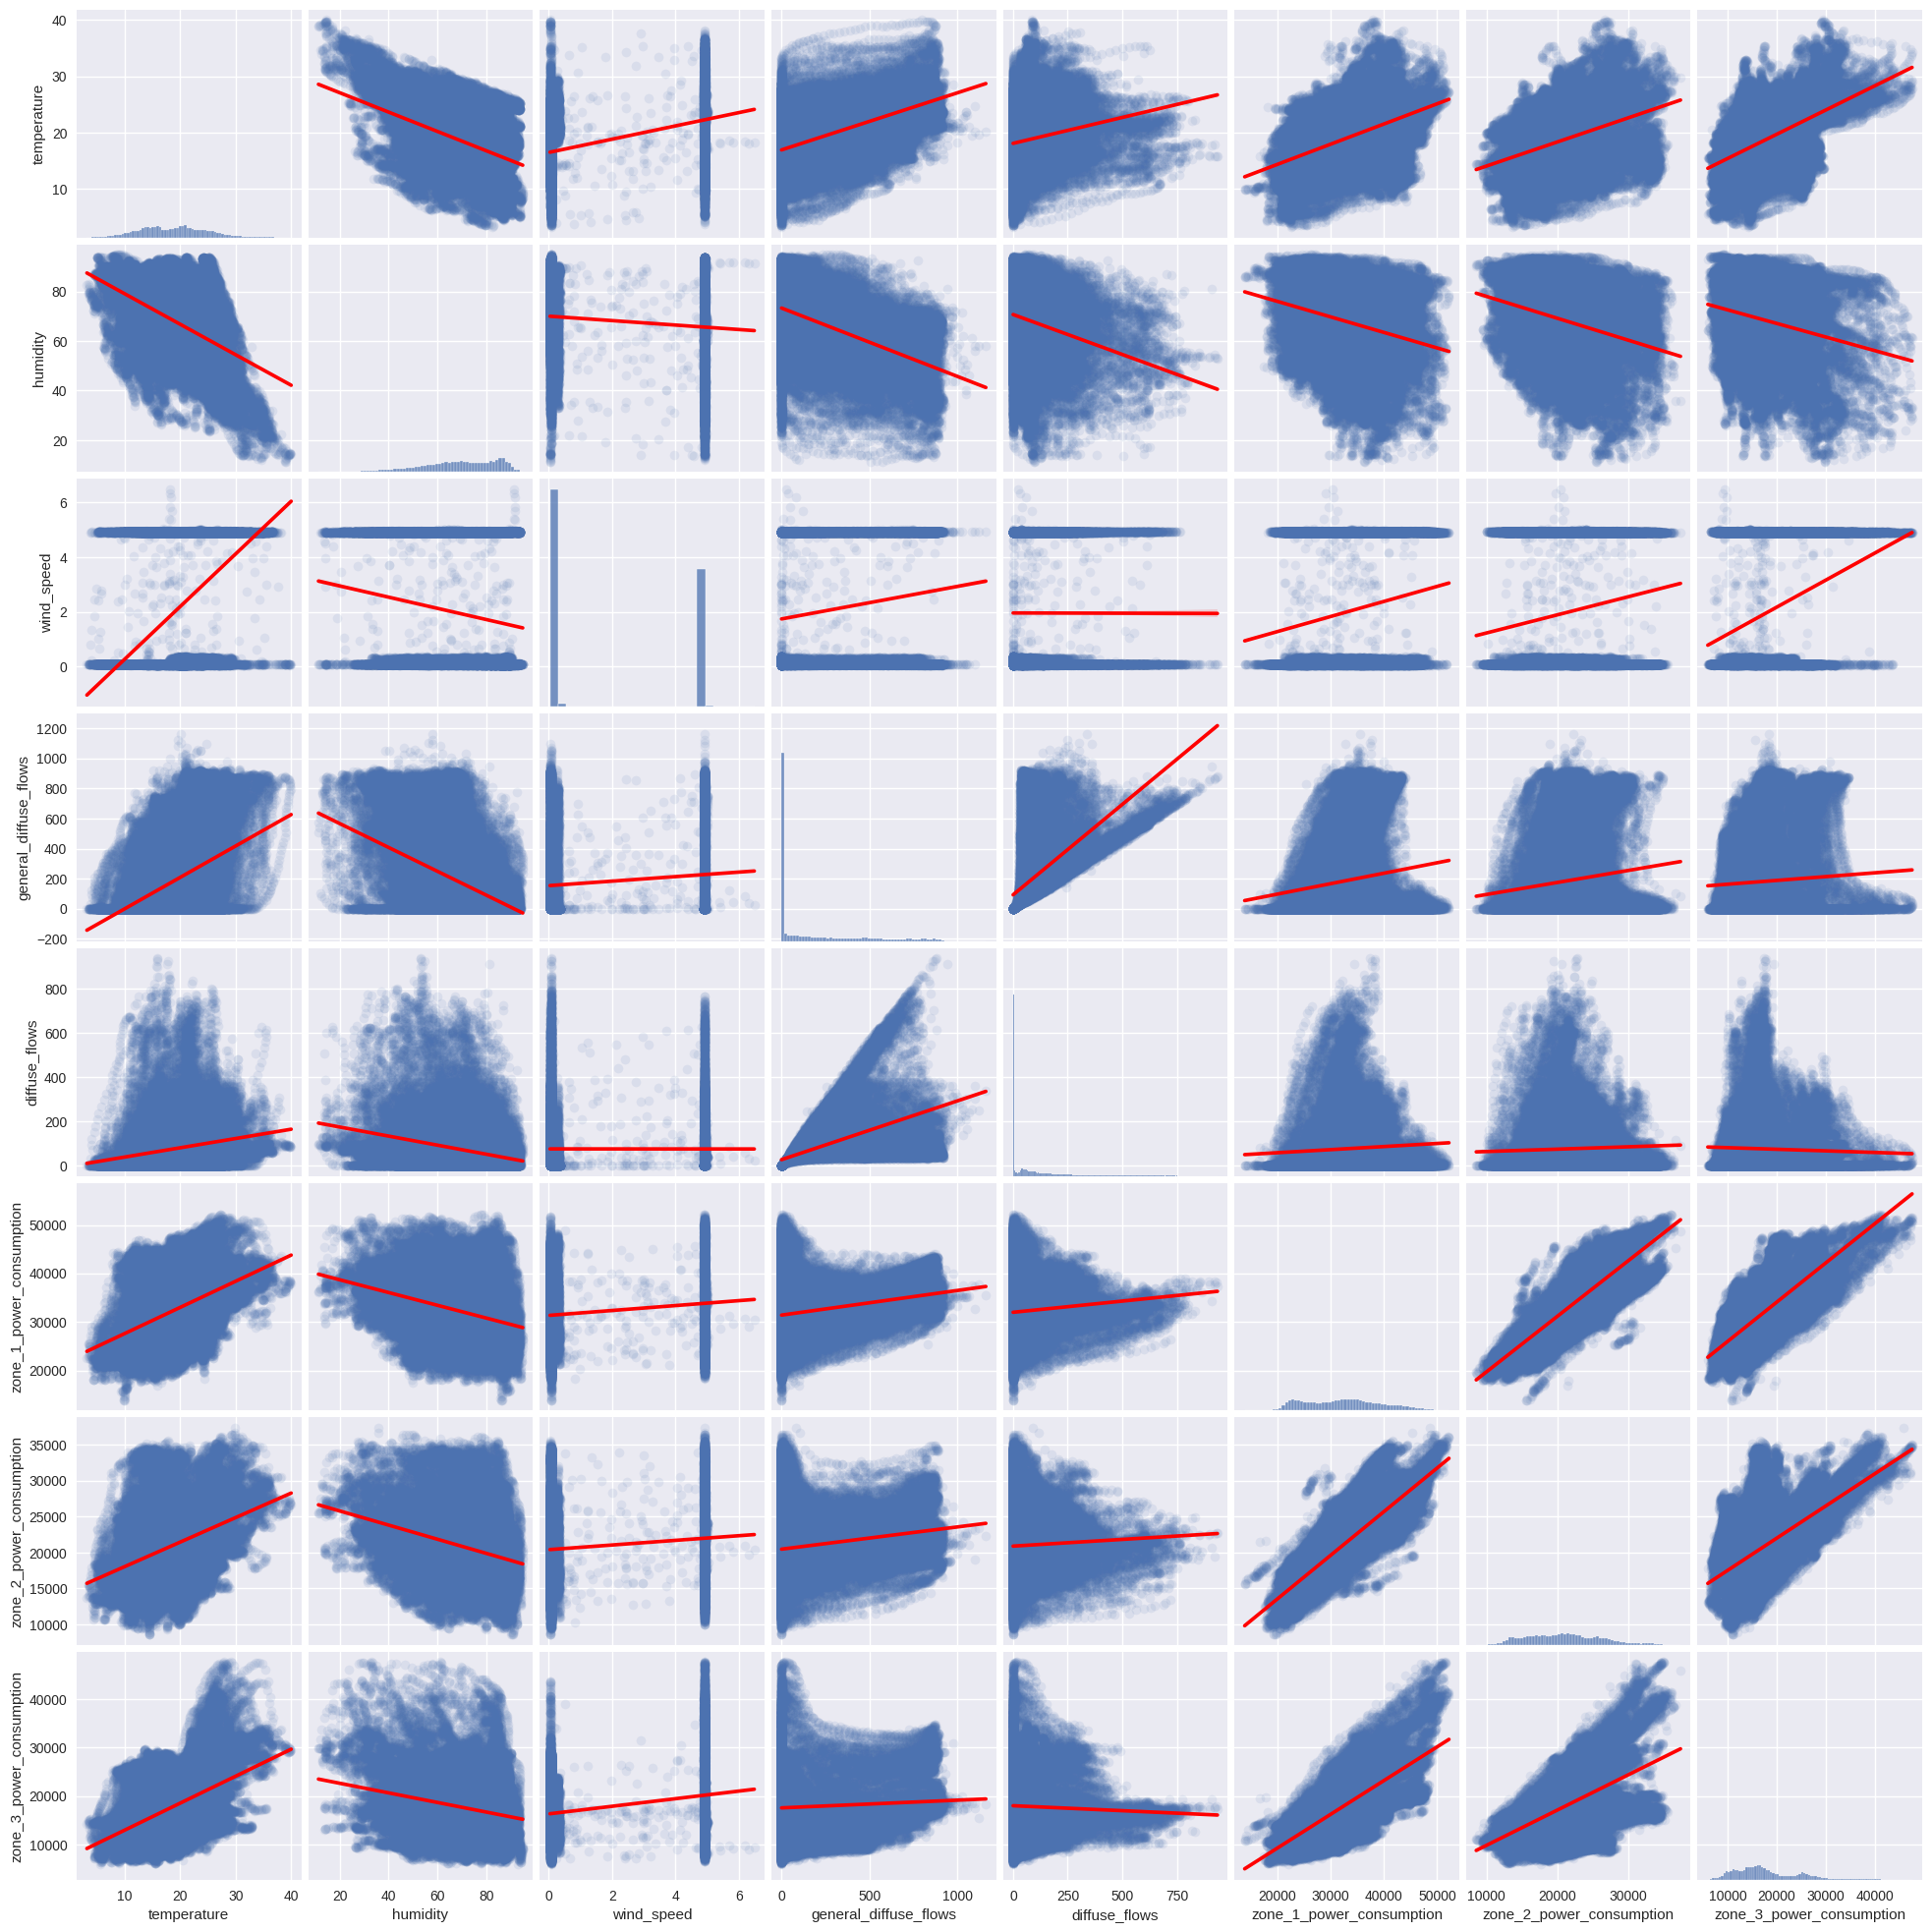

In [17]:
power_numeric = power.select_dtypes(include=np.number)
sns.pairplot(power_numeric, kind='reg', plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.1}})

### Feature Engineering

In [4]:
power['date_time'] = pd.to_datetime(power['date_time'])
power['month'] = power['date_time'].dt.month
power['day'] = power['date_time'].dt.day
power['hour'] = power['date_time'].dt.hour


In [ ]:
X 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)